In [21]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
def add(a:int, b:int)-> int:
    """Adds a and b
    
    Args:
        a: first int
        b: second int
    """
    return a+b

def multiply(a:int, b:int)-> int:
    """Multiply a and b
    
    Args:
        a: first int
        b: second int
    """
    return a*b

def divide(a:int, b:int)-> float:
    """Divide a and b
    
    Args:
        a: first int
        b: second int
    """
    return a/b

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

C:\Users\USER\AppData\Local\Temp\ipykernel_4144\735679136.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [4]:
from langchain_community.tools import ArxivQueryRun
from langchain_community.utilities import ArxivAPIWrapper

api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=5000)
arxiv= ArxivQueryRun(api_wrapper=api_wrapper_arxiv)

In [5]:
tools = [arxiv, tavily, add, multiply, divide]

In [8]:
from langchain_classic.chat_models import init_chat_model

llm= init_chat_model("groq:qwen/qwen3-32b")

llm_with_tools = llm.bind_tools(tools)

In [9]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

llm_with_tools.invoke([HumanMessage(content="What is the recent AI news")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent AI news. I need to figure out which tool to use here. Let me check the available functions.\n\nThe tools provided include arxiv, tavily_search_results_json, add, multiply, and divide. The arxiv function is for academic papers in specific fields, which might not be the best for current news. The add, multiply, and divide functions are for math operations, so not relevant here. \n\nThe remaining option is tavily_search_results_json, which is described as a search engine for comprehensive and trusted results, suitable for current events. That fits the user\'s request for recent AI news. \n\nSo I should use tavily_search_results_json with the query "recent AI news" to get the latest information. No need for academic papers here, so arxiv isn\'t necessary. The user probably wants up-to-date news articles, which tavily is designed for. \n\nI\'ll structure the tool call with the query parameter 

In [10]:
llm_with_tools.invoke([HumanMessage(content="What is the recent AI news")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': 'tzx0hqfkf',
  'type': 'tool_call'}]

In [11]:
from typing import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

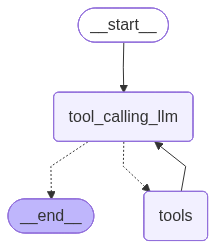

In [12]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


# Node definition
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# Building Graph
builder = StateGraph(State)

builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges( # if the latest message from the tool_calling_llm(assistant) is a tool call  -> tool condition routes to tools otherwise routes to end
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", "tool_calling_llm")


graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
messages = graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news from 11 November 2025, add 6 plus 6 and then multiply by 10")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news from 11 November 2025, add 6 plus 6 and then multiply by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (rz1pmdsw4)
 Call ID: rz1pmdsw4
  Args:
    query: top 10 recent AI news from 11 November 2025
  add (mg10fay38)
 Call ID: mg10fay38
  Args:
    a: 6
    b: 6
  multiply (8gh82e8mz)
 Call ID: 8gh82e8mz
  Args:
    a: 12
    b: 10
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Our latest commitments in AI and learning", "url": "https://blog.google/outreach-initiatives/education/ai-learning-commitments/", "content": "# Our latest commitments in AI and learning\n\nNov 11, 2025\n\nToday in London, we are bringing together experts in education and technology for our Google AI for Learning Forum. We’re also announcing

In [18]:
messages = [HumanMessage(content="Divide that by 5")]
messages= graph.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Divide that by 5
================================== Ai Message ==================================

The query "Divide that by 5" is incomplete because it does not specify what number should be divided by 5. Please provide the number you want divided by 5.


### Memory Saver

LangGraph can use acheckpointer to automatically save the graph state after each step.

This built in persistence layer gives us memory allowing LangGraph to pick up from the last state update.

One of the easiest checkpointers to use is the MemorySaver, an in-memory key-value store for Graph State.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

In [19]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


# Node definition
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# Building Graph
builder = StateGraph(State)

builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges( # if the latest message from the tool_calling_llm(assistant) is a tool call  -> tool condition routes to tools otherwise routes to end
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", "tool_calling_llm")



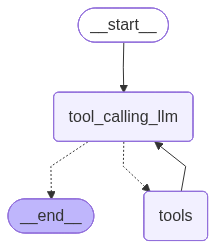

In [20]:
from langgraph.checkpoint.memory import MemorySaver

memory= MemorySaver()
graph_memory = builder.compile(checkpointer=memory)

# View
display(Image(graph_memory.get_graph().draw_mermaid_png()))

In [22]:
## Specify the thread

config={"configurable":{"thread_id":"1"}}
# Specify an Input
messages = [HumanMessage(content="Add 12 and 13.")]

messages = graph_memory.invoke({"messages":messages}, config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (rnckfr0ap)
 Call ID: rnckfr0ap
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The sum of 12 and 13 is:

$$
12 + 13 = 25
$$

\boxed{25}


In [23]:
messages = [HumanMessage(content="Add that number to 25")]

messages = graph_memory.invoke({"messages":messages}, config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (rnckfr0ap)
 Call ID: rnckfr0ap
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The sum of 12 and 13 is:

$$
12 + 13 = 25
$$

\boxed{25}
================================ Human Message =================================

Add that number to 25
================================== Ai Message ==================================
Tool Calls:
  add (3789a0n0f)
 Call ID: 3789a0n0f
  Args:
    a: 25
    b: 25
================================= Tool Message =================================
Name: add

50
================================== Ai Message ==================================

The sum of 25 and 25 is:

$$
25 + 25 = 50
$$

\boxed{50}


In [24]:
messages = [HumanMessage(content="Then multiply that number to 2")]

messages = graph_memory.invoke({"messages":messages}, config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (rnckfr0ap)
 Call ID: rnckfr0ap
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The sum of 12 and 13 is:

$$
12 + 13 = 25
$$

\boxed{25}
================================ Human Message =================================

Add that number to 25
================================== Ai Message ==================================
Tool Calls:
  add (3789a0n0f)
 Call ID: 3789a0n0f
  Args:
    a: 25
    b: 25
================================= Tool Message =================================
Name: add

50
================================== Ai Message ==================================

The sum of 25 and 25 is:

$$
25 + 25 = 50
$$

\boxed{50}
=============